In [15]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fatal: destination path 'AMPLify-Feedback' already exists and is not an empty directory.


In [2]:
tf.config.run_functions_eagerly(True)

seq_train = np.load("AMPLify-Feedback/processed_data/cv/seq_train_1.npy")
state_train = np.load("AMPLify-Feedback/processed_data/cv/state_train_1.npy")
label_train = np.load("AMPLify-Feedback/processed_data/cv/label_train_1.npy")
seq_test = np.load("AMPLify-Feedback/processed_data/cv/seq_test_1.npy")
state_test = np.load("AMPLify-Feedback/processed_data/cv/state_test_1.npy")
label_test = np.load("AMPLify-Feedback/processed_data/cv/label_test_1.npy")
seq_train = np.expand_dims(seq_train, 2).astype("float32")
seq_test = np.expand_dims(seq_test, 2).astype("float32")
state_train = np.expand_dims(state_train, 2).astype("float32")
state_test = np.expand_dims(state_test, 2).astype("float32")

train_dataset = tf.data.Dataset.from_tensor_slices(((seq_train, state_train), label_train))
train_dataset = train_dataset.shuffle(buffer_size=len(seq_train))
train_dataset = train_dataset.batch(100)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(((seq_test, state_test), label_test))
test_dataset = test_dataset.batch(100)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [24]:
@tf.function
def train_step(seqs, states, labels):
    with tf.GradientTape() as tape:
        predictions = model((seqs, states))
        loss = loss_function(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # train_accuracy_metric.update_state(labels, predictions)
    return loss

@tf.function
def val_step(seqs, states, labels):
    predictions = model((seqs, states))
    loss = loss_function(labels, predictions)
    # val_accuracy_metric.update_state(labels, predictions)
    return loss

In [46]:
class ActivityPredictor(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.Embed = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_0"),
            tf.keras.layers.MaxPooling1D(3, name="MaxPool_0"),
            tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_1"),
            tf.keras.layers.MaxPooling1D(3, name="MaxPool_1"),
            tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_2"),
            tf.keras.layers.MaxPooling1D(3, name="MaxPool_2"),
            # tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_3"),
            # tf.keras.layers.MaxPooling1D(3, name="MaxPool_3"),
            # tf.keras.layers.Conv1D(1, 1, activation='relu', name="Conv1D_Fusion"),
            # tf.keras.layers.Flatten(name="Flatten"),
            # tf.keras.layers.Dense(128, activation="relu", name="EmbedState"),
            # tf.keras.layers.LayerNormalization(name="LayerNorm_0"),
        ], name="EmbedState")

        self.cnn = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_0"),
            tf.keras.layers.MaxPooling1D(3, name="MaxPool_0"),
            tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_1"),
            tf.keras.layers.MaxPooling1D(3, name="MaxPool_1"),
            tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_2"),
            tf.keras.layers.MaxPooling1D(3, name="MaxPool_2"),
            tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_3"),
            tf.keras.layers.MaxPooling1D(3, name="MaxPool_3"),
            # tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_4"),
            # tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_5"),
            # tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_6"),
            # tf.keras.layers.Conv1D(1, 1, activation='relu', name="Conv1D_Fusion"),
            # tf.keras.layers.Flatten(name="Flatten"),
            # tf.keras.layers.LSTM(1024, name="GRU_0", return_sequences=True),
            # tf.keras.layers.GRU(1024, name="GRU_1", return_sequences=True),
            # tf.keras.layers.GRU(128, name="GRU_2", return_sequences=True),
            # tf.keras.layers.GRU(128, name="GRU_3", return_sequences=True),
            # tf.keras.layers.LSTM(1024, name="GRU_4", return_sequences=False),
            # tf.keras.layers.Dense(512, activation="relu", name="CNN_Out"),
            # tf.keras.layers.LayerNormalization(name="LayerNorm_1"),
        ], name="cnn")

        self.fcn = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_0"),
            # tf.keras.layers.MaxPooling1D(3, name="MaxPool_0"),
            # tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_1"),
            # tf.keras.layers.MaxPooling1D(3, name="MaxPool_1"),
            # tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_2", padding="same"),
            # tf.keras.layers.MaxPooling1D(3, name="MaxPool_2"),
            # tf.keras.layers.Conv1D(64, 3, activation='relu', name="Conv1D_3", padding="same"),
            # tf.keras.layers.MaxPooling1D(3, name="MaxPool_3"),
            tf.keras.layers.Conv1D(1, 1, activation='relu', name="Conv1D_Fusion"),
            tf.keras.layers.Flatten(name="Flatten"),
            tf.keras.layers.Dense(1024, activation="relu", name="Dense_0"),
            # tf.keras.layers.Dense(1024, activation="relu", name="Dense_1"),
            # tf.keras.layers.Dense(1024, activation="relu", name="Dense_2"),
            # tf.keras.layers.Dense(1024, activation="relu", name="Dense_3"),
            tf.keras.layers.Dense(64, activation="relu", name="Dense_4"),
            # tf.keras.layers.LayerNormalization(name="LayerNorm_3"),
        ], name="fcn")
        self.Output = tf.keras.layers.Dense(1, activation="linear", name="Output")
        # self.call_layernorm = tf.keras.layers.LayerNormalization(name="LayerNorm_2")

    def call(self, data):
        [seq, state] = data
        x0 = self.cnn(seq)
        x1 = self.Embed(state)
        x = tf.keras.layers.Concatenate(axis=1)([x0, x1])
        # x = self.call_layernorm(x)
        x = self.fcn(x)
        x = self.Output(x)
        return x

model = ActivityPredictor()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_function = tf.keras.losses.MeanSquaredError()
# train_accuracy_metric = tf.keras.metrics.BinaryAccuracy()
# val_accuracy_metric = tf.keras.metrics.BinaryAccuracy()
model.compile(optimizer=optimizer, loss=loss_function, metrics=["accuracy"])

In [47]:
EPOCHS = 20

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print('-' * 40)

    # Training Loop
    total_loss = 0
    num_batches = 0
    for (batch_seqs, batch_states), batch_labels in train_dataset:
        total_loss += train_step(batch_seqs, batch_states, batch_labels)
        num_batches += 1
    train_loss = total_loss / num_batches
    # train_accuracy = train_accuracy_metric.result()

    # Test Loop
    total_test_loss = 0
    num_test_batches = 0
    for (batch_seqs, batch_states), batch_labels in test_dataset:
        total_test_loss += val_step(batch_seqs, batch_states, batch_labels)
        num_test_batches += 1
    test_loss = total_test_loss / num_test_batches
    # val_accuracy = val_accuracy_metric.result()

    # Logging Results
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Resetting Metrics
    # train_accuracy_metric.reset_states()
    # val_accuracy_metric.reset_states()


Epoch 1/20
----------------------------------------
Train Loss: 0.7542
Validation Loss: 0.4394

Epoch 2/20
----------------------------------------
Train Loss: 0.4390
Validation Loss: 0.4290

Epoch 3/20
----------------------------------------
Train Loss: 0.4267
Validation Loss: 0.4169

Epoch 4/20
----------------------------------------
Train Loss: 0.4101
Validation Loss: 0.4047

Epoch 5/20
----------------------------------------
Train Loss: 0.3955
Validation Loss: 0.3965

Epoch 6/20
----------------------------------------
Train Loss: 0.3826
Validation Loss: 0.3822

Epoch 7/20
----------------------------------------
Train Loss: 0.3726
Validation Loss: 0.3754

Epoch 8/20
----------------------------------------
Train Loss: 0.3631
Validation Loss: 0.3750

Epoch 9/20
----------------------------------------
Train Loss: 0.3556
Validation Loss: 0.3622

Epoch 10/20
----------------------------------------
Train Loss: 0.3481
Validation Loss: 0.3736

Epoch 11/20
--------------------------

In [50]:
pred = model.predict((seq_test, state_test))

  7/154 [>.............................] - ETA: 2s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


154/154 [==============================] - 3s 19ms/step


Text(0, 0.5, 'Predicted')

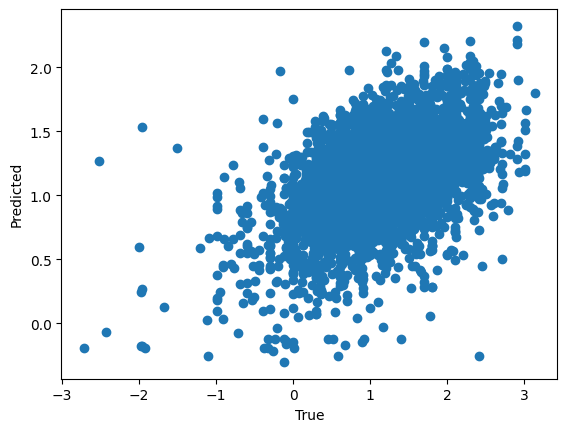

In [55]:
plt.scatter(label_test, pred)
plt.xlabel("True")
plt.ylabel("Predicted")